# 1) Notes: 

## THERE IS A "BUMP" IN MANTLE TEMPERATURE AT LATE TIMES WHEN USING THE EQUATION FOR Q(TAU_HEAT) FROM THE PAPER (I.E., tau_decay/(rho_m * c_p * T_ref/Q_0) INSTEAD OF THE SMOOTH EVOLUTION OF MANTLE TEMPERATURE IN TAD'S CODE USING (tau_decay/(rho_m * c_p * T_ref/F_0). COULD THIS BUMP BE REAL??? WHY DOES CHANGING THE NON-DIMENSIONAL TIMESCALE CAUSE THIS?
## --> INTERESTINGLY, THIS ONLY REMOVES THE BUMP WHEN THE TIMESCALE IS CHANGED IN THE EXPONENTIAL, WHILE THE REST OF THE EQUATION IS THE SAME AS IN THE PAPER. (XXXX IS THIS ACTUALLY HAPPENING? TEST THESE VALUES AGAIN LATER XXXX)

## ACCORDING TO TAD, REGASSING CHECK IS "WONKY" -- FIGURE OUT A BETTER WAY TO DO THIS IN SIMPLE ANALYTIC MODEL (OR USE A MORE COMPLICATED MODEL, I.E. LAURA'S)

## TOTAL WATER MASS FRACTION VARYING WITH TIME FOR LOSS -- CHECK EACH FUNCTION THAT DEPENDS ON THE TOTAL VALUE, AND NOT JUST THE INITIAL VALUE!

# 2) XXXX Things to vary, once code runs with loss XXXX
## Make robust to dessication -- should still be able to cycle if one reservoir is empty (currently the integrations don't work for SS and hybrid models in this limit) --> i.e., catches for rates going to 0 (or infinity), similar to what Tad has done, in EVERY function!!! 
## If x and s become dessicated, switch to the slower dx/dt, etc. calculations from the other code, to allow the integration to continue within this notebook
## CHECK regassing/degassing rates from Tad's paper and make sure they match when they are dimensionalized! If not, my conversions are WRONG!
## - total initial water [a) surface, b) interior]
## - water loss [c) rate, d) timescale]
## -- *Sensitivity Analysis*

# 3) XXXX Code Improvements XXXX
## - Laura's code
## - Better atmospheric loss (diffusion-limited escape; as opposed to energy-limited); accounting for planetary climate, atmospheric composition; wind-driven --> magnetic field --> mantle convection --> dynamo in outer core; hydrogen-generation --> photolysis of water and methane (our assumptions for now), OR serpentinization if iron-rich rock
## - Convection speed and regassing efficiency

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Need to divide constants into three categories --
# XXXX SEE OTHER RECODED NOTEBOOK FOR DESCRIPTIONS OF ALL CONSTANTS XXXX

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3

In [3]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid, params1, params2, params3):
    
    return np.exp(lnf_w(x_twid, params1, params2, params3)) / (np.exp(lnf_w(1., params1, params2, params3)))

In [4]:
#print((np.exp(lnf_w(1., params1, params2, params3))))

In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(T_twid, x_twid, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    f_w = np.exp(lnf_w(x_twid,params1,params2,params3)) #lnf_w needs non-dimensionalized x
    
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    if f_w > f_w_min:
        return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))
    elif f_w <= f_w_min:
        return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
#print(eta(0.5,1.,params1,params2,params3))

In [7]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid * omega_0 * f_btwid / f_M # mantle water mass fraction
    T = T_twid * T_ref #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T_twid,x_twid,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def tau_decay_twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return 2.0e9*year/(rho_m*c_p*T_ref/F_0(M,params1,params2,params3))
    # return 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay

def F_0twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return F_0(M,params1,params2,params3)/Q_0

In [8]:
# Things that need to be calculated with constants and above functions:
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
eta_0 = 1.e21/eta_scale
f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = f_w_min/np.exp(lnf_w(1.,params1,params2,params3)) #CONSERVATIVELY CHOSEN AS 1e-5 FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

# CA Model, using scipy.integrate --> GOOD! LOSS INCLUDED!
## scipy.optimize, with the integrator option 'vode', seems to be the best for this.

In [9]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum fugacity, to avoid f_wtwid --> 0 and eta --> infinity.  
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        return rg_CA - dg_CA
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            return ((gtwid(M)**2.)*s_twid)**sigma - 0.
        else:
            return (d_b/d_hE) - 0. 
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        
        return 0. - (Xtwid**-1.)*x_twid*(1./f_degasE) #from degassing check from CA2014 paper, or else degas blows up
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    #loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)
    # loss factor is 10 times the initial degassing rate (FOR NOW)
    
    loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 75. #EXTREME LOSS -- WILL THE CODE WORK????
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            ds_twid = 0. - ((gtwid(M)**2.)*s_twid)**sigma - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        else:
            ds_twid = 0. - (d_b/d_hE) - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing or lose if no water on surface
        
        return (Xtwid**-1.)*x_twid*(1./f_degasE) - 0. - 0. #from degassing check from CA2014 paper, or else degas blows up
    
    else: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [10]:
### Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Regassing check from CA2014
    if s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE): #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    elif s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma >= (d_b/d_hE):
        return (d_b/d_hE)
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Degassing check from CA2014
    if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    elif x_twid > 0. and s_twid <= 0.:
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
        return 0.
    
def f_loss_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 75. # EXTREME LOSS -- WILL THE CODE WORK???
    
    # OPTION 1: SEE FIGURE
    #if s_twid > 0.: #normal loss
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #else: #if s_twid <= 0; no loss
    #    return 0.
    
    if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
        dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else:
        dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
    #Regassing check from CA2014 paper
    if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
        rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
    else:
        rg_CA = (d_b/d_hE)
        
    ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    
    # OPTION 2: SEE FIGURE
    # Can't lose more water than is actually on the surface.
    #if s_twid > 0. and s_twid + (ds_twid*dt) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid > 0. and s_twid + (ds_twid*dt) < 0.:
    #    return (s_twid/dt)
    #elif s_twid <= 0.:
    #    return 0.
    
    # OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    #What if loss rate doesn't depend on surface water -- just see how it looks
    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)


In [11]:
# Multiply by omega_0*f_btwid*M_E to get amount of water in kg!

def omega_hydr_twid_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    d_h = d_hE*((gtwid(M)**2.)*s_twid)**sigma #Eqn (35) in paper
    
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)

In [12]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_CA).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt)+1)
T_array_CA = np.zeros(int(t1/dt)+1)
x_array_CA = np.zeros(int(t1/dt)+1)
s_array_CA = np.zeros(int(t1/dt)+1)
regas_array_CA = np.zeros(int(t1/dt)+1)
degas_array_CA = np.zeros(int(t1/dt)+1)
loss_array_CA = np.zeros(int(t1/dt)+1)
omega_hydr_array_CA = np.zeros(int(t1/dt)+1)
eta_array_CA = np.zeros(int(t1/dt)+1)

# Initial values in the arrays.
t_array_CA[0] = t0
T_array_CA[0] = z0[0]
x_array_CA[0] = z0[1]
s_array_CA[0] = z0[2]
regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_CA[0] = omega_hydr_twid_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
eta_array_CA[0] = eta(z0[0], z0[1], params1, params2, params3)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:
for idx in range(1,len(t_array_CA)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_CA[idx] = r.t
        T_array_CA[idx] = r.y[0]
        x_array_CA[idx] = r.y[1]
        s_array_CA[idx] = r.y[2]
        regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
        eta_array_CA[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
        
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_CA[idx] = t_array_CA[idx-1] + dt
        
        T_array_CA[idx] = T_array_CA[idx-1] + \
            f_delta_temp_CA(t_array_CA[idx-1], T_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        x_array_CA[idx] = x_array_CA[idx-1] + \
            f_delta_x_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        s_array_CA[idx] = s_array_CA[idx-1] + \
            f_delta_s_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_CA[idx] = f_regas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        degas_array_CA[idx] = f_degas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        loss_array_CA[idx] = f_loss_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
        eta_array_CA[idx] = eta(T_array_CA[idx], x_array_CA[idx], params1, params2, params3)
        
    #idx = idx + 1
    
# Mass of water in hydrated layer
M_hydr_CA = omega_hydr_array_CA*2.3e-4*1.3*M_E #[kg]

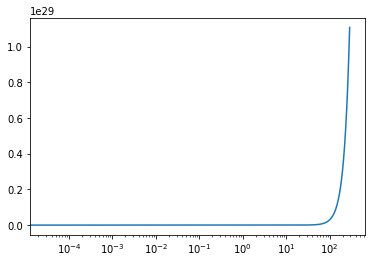

In [13]:
plt.semilogx(t_array_CA*2.87, eta_array_CA)

In [ ]:
print(x_array_CA[0] + s_array_CA[0])
print(x_array_CA[1] + s_array_CA[1])
print(x_array_CA[2] + s_array_CA[2])
print(x_array_CA[5400] + s_array_CA[5400])
print(t_array_CA[5400]/tau(M_E,params1,params2,params3)/year/1e6)
#Loss factor 75, all water lost by ~158 Myr --> Planet DESICCATED!

Text(0, 0.5, 'Mantle Temperature [K]')

<Figure size 1224x540 with 0 Axes>

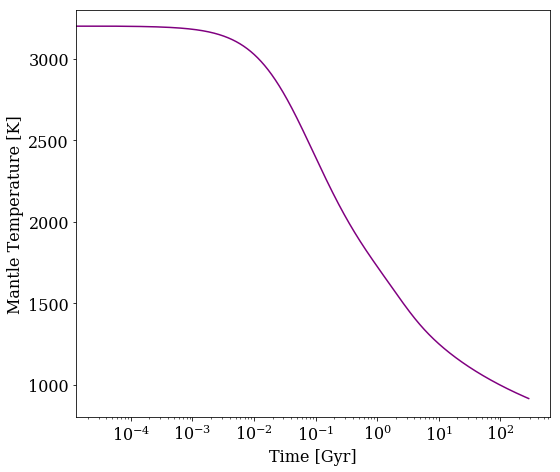

In [14]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple')
plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_CA_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_Model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


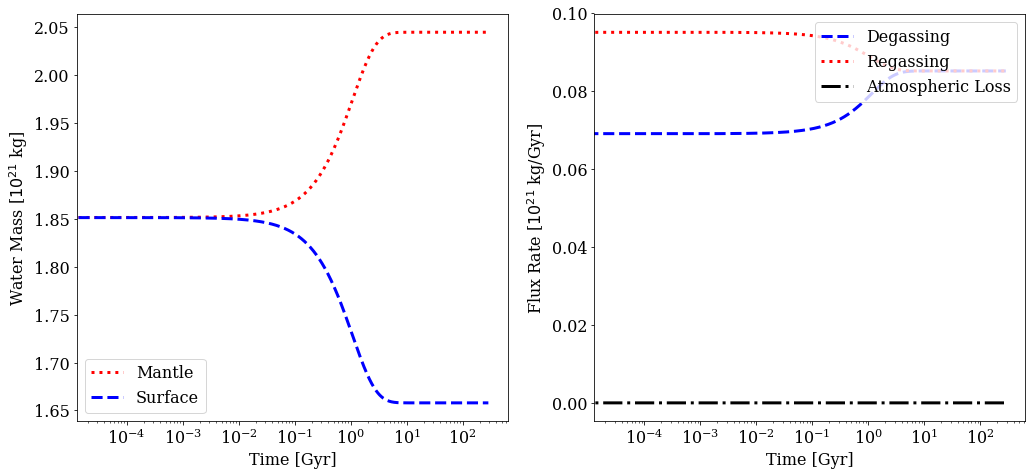

In [15]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

ax1 = plt.subplot(1,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_CA*2.87, ((s_array_CA*kg_conv/1000./1.0e18)-M_hydr_CA/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_CA*2.87, M_hydr_CA/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax2 = plt.subplot(1,2,2)
plt.semilogx(t_array_CA*2.87, (degas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, (regas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([0,0.2])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
print(x_array_CA[0]+s_array_CA[0])
print(x_array_CA[-1]+s_array_CA[-1])

In [ ]:
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlim([1e-2,1.])

# SS Model, using scipy.integrate

In [16]:
# Define functions to be used within this model (and hybrid), based on mass.

def D(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M, params1, params2, params3, params4):
    
    return D(M, params1, params2, params3, params4)/Sigma(M, params1, params2, params3, params4)

def Pitwid(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/D(M, params1, params2, params3, params4)

def D_2(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1., params1, params2, params3))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(1.+beta))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_min**beta)*((temp_twid-T_stwid)**(1.+beta))

def Pitwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

#tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [23]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid < 0:
                return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid < 0:
                return 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid < 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4): # NEED TO ADD LOSS TO THIS 
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    loss_factor = 10.*loss_factor # for cycling to look good
    #loss_factor = 0.
    #loss_factor = 100.*loss_factor # EXTREME loss test
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid < 0:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. \
                    - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            elif s_twid < 0:
                return 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid < 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [24]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.
    
def f_loss_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    loss_factor = 10.*loss_factor #for cycling to look good
    #loss_factor = 0.
    #loss_factor = 100.*loss_factor # EXTREME loss test
    
# OPTION 2: CAN ADD OPTION 1 OR 3 BASED ON CA RESULTS LATER XXXXXX
    if s_twid > 0.: #normal loss
        return loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    elif s_twid <= 0.: #no loss
        return 0.

In [25]:
def omega_hydr_twid_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)
    

In [26]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_SS).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M, params1, params2, params3, params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt)+1)
T_array_SS = np.zeros(int(t1/dt)+1)
x_array_SS = np.zeros(int(t1/dt)+1)
s_array_SS = np.zeros(int(t1/dt)+1)
regas_array_SS = np.zeros(int(t1/dt)+1)
degas_array_SS = np.zeros(int(t1/dt)+1)
loss_array_SS = np.zeros(int(t1/dt)+1)
omega_hydr_array_SS = np.zeros(int(t1/dt)+1)
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_SS[0] = t0
T_array_SS[0] = z0[0]
x_array_SS[0] = z0[1]
s_array_SS[0] = z0[2]
regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_SS[0] = f_loss_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_SS[0] = omega_hydr_twid_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:
for idx in range(1,len(t_array_SS)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_SS[idx] = r.t
        T_array_SS[idx] = r.y[0]
        x_array_SS[idx] = r.y[1]
        s_array_SS[idx] = r.y[2]
        regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_SS[idx] = f_loss_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_SS[idx] = t_array_SS[idx-1] + dt
        
        T_array_SS[idx] = T_array_SS[idx-1] + \
            f_delta_temp_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        x_array_SS[idx] = x_array_SS[idx-1] + \
            f_delta_x_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        s_array_SS[idx] = s_array_SS[idx-1] + \
            f_delta_s_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_SS[idx] = f_regas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        degas_array_SS[idx] = f_degas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        loss_array_SS[idx] = f_loss_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
    
    #idx = idx + 1
    
# Mass of water in hydrated layer
M_hydr_SS = omega_hydr_array_SS*2.3e-4*1.3*M_E #[kg]

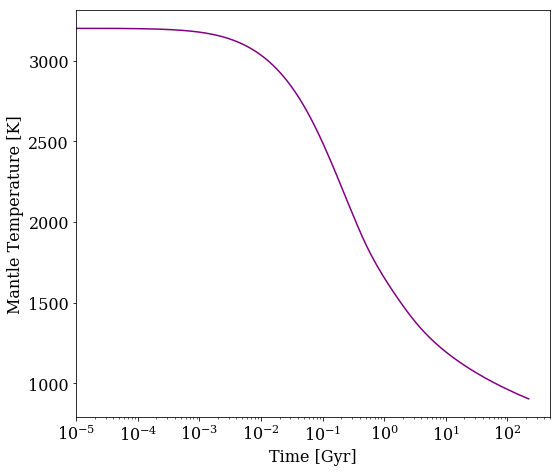

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple')
#plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_SS_model_MantleTemp_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_SS_model_MantleTemp_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


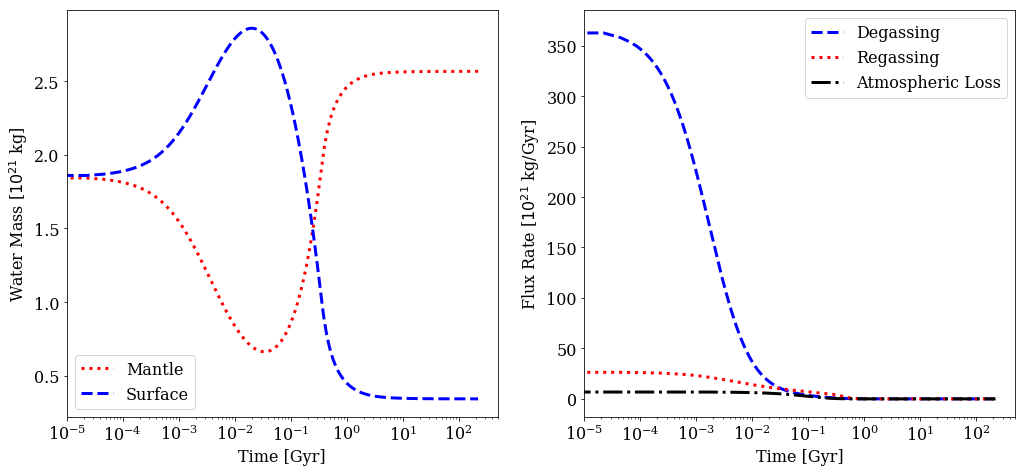

In [28]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS*2.22, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS*2.22, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, (degas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, (regas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_SS*2.22, (loss_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_SS_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_extremeloss.pdf', bbox_inches='tight')

# Hybrid Model, using scipy.integrate --> GOOD!
## This is the quickest way to run through this cycling, so just code it this way from the beginning.

In [29]:
# Many functions have already been defined for the SS model -- only define new things here.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [40]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                dg_hyb
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                dg_hyb
        elif s_twid < 0:
             return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid < 0:
             return 0. - 0.
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though)
        return 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    #loss_factor = 10.*loss_factor # same as SS for now (10x CA)
    loss_factor = 100.*loss_factor #EXTREME loss
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = dg_hyb - \
                (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = dg_hyb - \
                (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid < 0:
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid < 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        if s_twid + (ds_twid*dt) >= 0.:
            return ds_twid
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [41]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.:
        
        if s_twid < 0.:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid
        else:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
    
    elif x_twid <= 0.:
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    #loss_factor = 10.*loss_factor
    loss_factor = 100.*loss_factor #EXTREME loss
    
    if s_twid > 0.: #normal loss
        return loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    elif s_twid <= 0.: #no loss
        return 0.

In [42]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

In [43]:
# Set initial conditions.
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_hyb).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt)+1)
T_array_hyb = np.zeros(int(t1/dt)+1)
x_array_hyb = np.zeros(int(t1/dt)+1)
s_array_hyb = np.zeros(int(t1/dt)+1)
regas_array_hyb = np.zeros(int(t1/dt)+1)
degas_array_hyb = np.zeros(int(t1/dt)+1)
loss_array_hyb = np.zeros(int(t1/dt)+1)
omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_hyb[0] = t0
T_array_hyb[0] = z0[0]
x_array_hyb[0] = z0[1]
s_array_hyb[0] = z0[2]
regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)

# Integrate the above function.
idx = 1
#while r.successful() and r.t < t1:
for idx in range(1,len(t_array_hyb)):
    
    if r.successful() == True:
        r.integrate(r.t+dt)
        t_array_hyb[idx] = r.t
        T_array_hyb[idx] = r.y[0]
        x_array_hyb[idx] = r.y[1]
        s_array_hyb[idx] = r.y[2]
        regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
    
    elif r.successful() == False:
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
        t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
        T_array_hyb[idx] = T_array_hyb[idx-1] + \
            f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        x_array_hyb[idx] = x_array_hyb[idx-1] + \
            f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        s_array_hyb[idx] = s_array_hyb[idx-1] + \
            f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
        regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
    
    #idx = idx + 1
    
# Mass of water in hydrated layer
M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


<Figure size 1224x540 with 0 Axes>

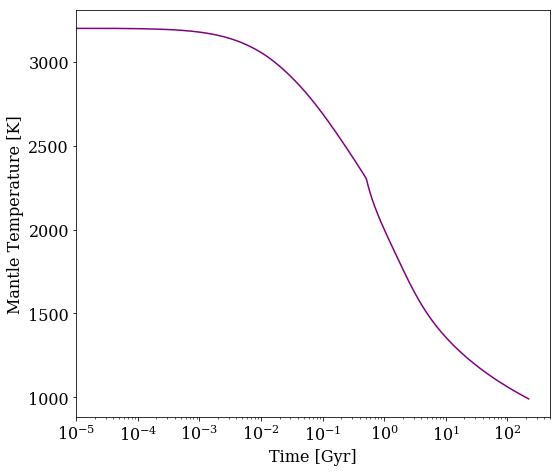

In [44]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_hyb*2.22, T_array_hyb*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_hyb_model_MantleTemp_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_MantleTemp_exploss.pdf', bbox_inches='tight')
plt.savefig('Recoded_hyb_model_MantleTemp_extremeloss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply


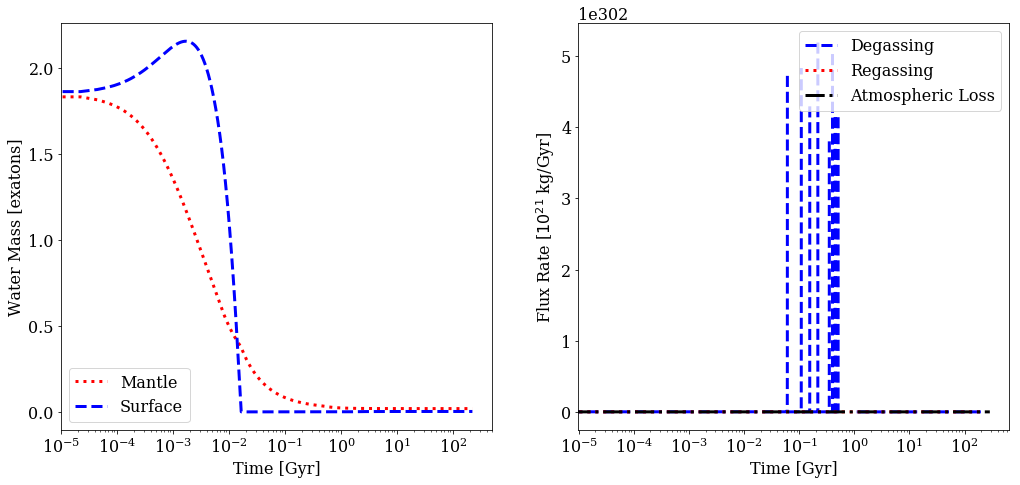

In [45]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_hyb*2.22, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb*2.22, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_hyb*2.22, (degas_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb*2.22, (regas_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')